In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import torch
import copy
import matplotlib.pyplot as plt
from ncnn import NashCascadeNeuralNetwork as ncnn
from ncnn import train_model as train_ncnn
from ncn import NashCascadeNetwork as ncn
# Precipitation standard variable name used in the ncnn model interface
PRECIP_SVN = "atmosphere_water__liquid_equivalent_precipitation_rate"
PRECIP_SVN_SEQ = "atmosphere_water__liquid_equivalent_precipitation_rate_seq"
DO_PLOT = True
N_TIMESTEPS = 300

In [3]:
network_precip_input_list = []
count = 0
for i in range(N_TIMESTEPS):

    ###########################################################################
    if count == 0:
        network_precip_input_list.append(3.0)
    elif count > 39:
        network_precip_input_list.append(3.0)
    else:
        network_precip_input_list.append(0.0)
    if count == 50:
        count = 0
    count+=1
    ###########################################################################
network_precip_tensor = torch.tensor(network_precip_input_list, requires_grad=True)
total_mass_precip_in = torch.sum(network_precip_tensor)

Initial Mass in network at start: 4.0
Initial Mass in network: 4.0
Final Mass in network: 60.2
Total Mass out of network 141.8
Total precipitation into network 198.0
Mass balance for network is 0.000
Mass balance for network is 0.000


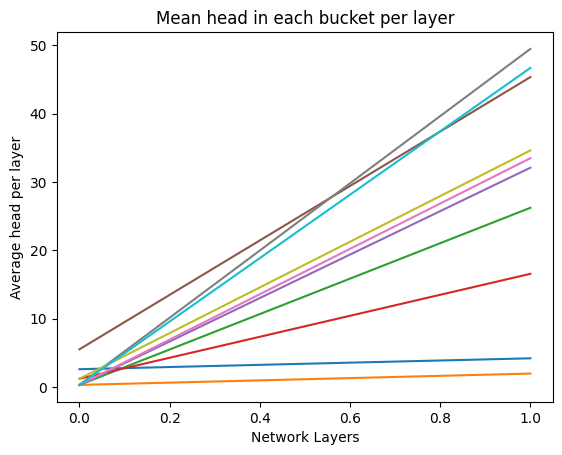

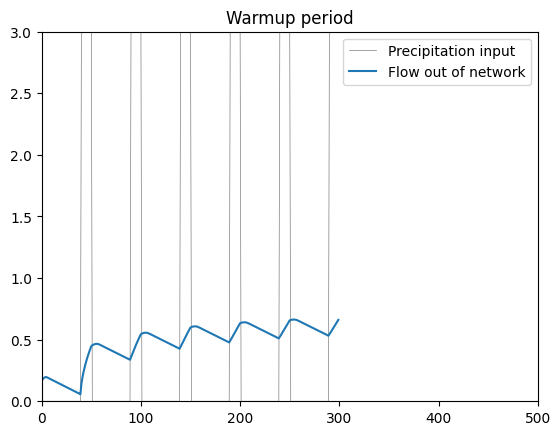

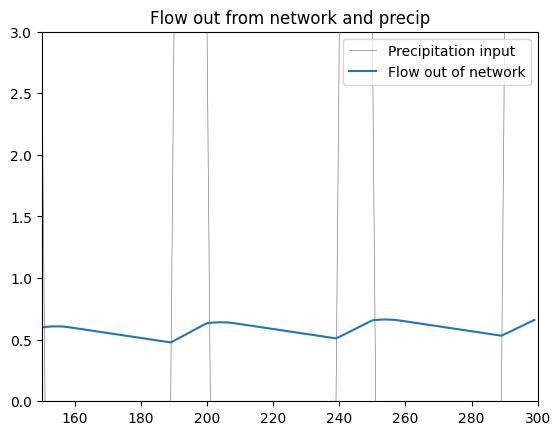

In [4]:
# Example 0
bucket_net = ncn(cfg_file="./config_0.json")
bucket_net.initialize()
bucket_net.summarize_network()
inital_mass_in_network = torch.sum(torch.tensor([tensor.item() for tensor in bucket_net.sum_H_per_layer]))
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_0 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_net.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    bucket_net.forward()
    network_outflow_list_0.append(bucket_net.network_outflow.item())
    bucket_net.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_net.mean_H_per_layer])

network_outflow_tensor_0 = torch.tensor(network_outflow_list_0, requires_grad=True)
bucket_net.report_out_mass_balance()
bucket_net.detach_ncn_from_graph()
bucket_net.theta.detach()

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 500

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_0)-(len(network_outflow_list_0)/2))
    endplt = int(len(network_outflow_list_0))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

Initial Mass in network at start: 4.0
Initial Mass in network: 4.0
Final Mass in network: 4.1
Total Mass out of network 197.9
Total precipitation into network 198.0
Mass balance for network is 0.000
Mass balance for network is 0.000


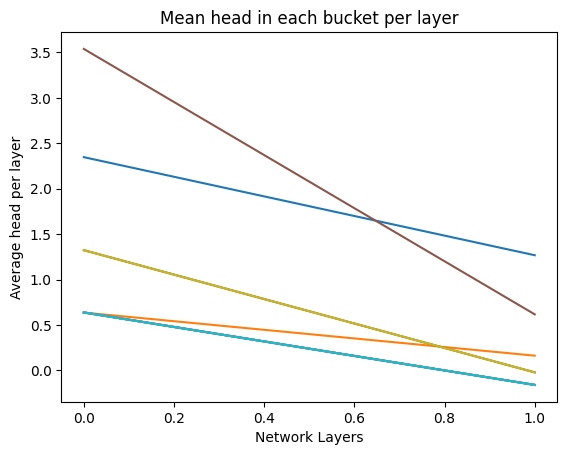

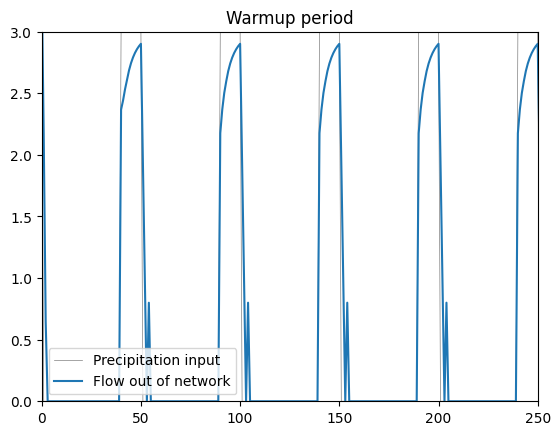

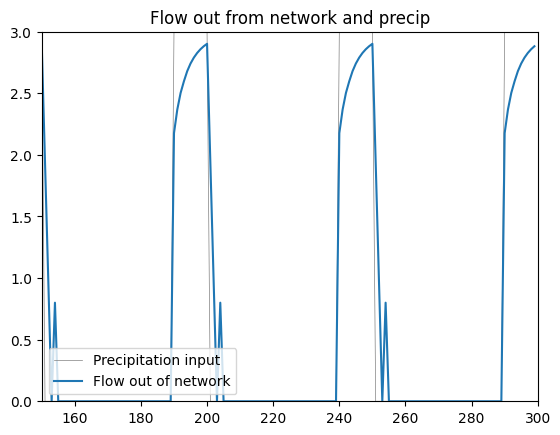

In [5]:
# Example 1
bucket_nn = ncnn(cfg_file="./config_1.json")
bucket_nn.ncn.initialize_theta_values()
inital_mass_in_network = torch.sum(torch.stack(bucket_nn.ncn.sum_H_per_layer)).item()
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_1 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_nn.ncn.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    if bucket_nn.ncn.do_predict_theta_with_lstm:
        sequence_tensors = []
        tensor_device = bucket_nn.ncn.network[0]['H'].device
        tensor_dtype = torch.float32
        if i >= bucket_nn.ncn.input_u_sequence_length:
            sequence_tensors = [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                for item in network_precip_input_list[i-bucket_nn.ncn.input_u_sequence_length:i]]
        else:
            desired_tensor_shape = (1,)
            padding_size = bucket_nn.ncn.input_u_sequence_length - i
            padding_tensors = [torch.zeros(desired_tensor_shape, device=tensor_device, dtype=tensor_dtype) 
                            for _ in range(padding_size)]
            sequence_tensors = padding_tensors + [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                                for item in network_precip_input_list[:i]]
        sequence = torch.stack(sequence_tensors).view(1, -1)
        bucket_nn.ncn.set_value(PRECIP_SVN_SEQ, sequence)


    bucket_nn.ncn.forward()
    network_outflow_list_1.append(bucket_nn.ncn.network_outflow.item())
    bucket_nn.ncn.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_nn.ncn.mean_H_per_layer])

###########################################################################
network_outflow_tensor_1 = torch.tensor(network_outflow_list_1, requires_grad=True)
bucket_nn.ncn.report_out_mass_balance()

origional_bucket_theta = copy.deepcopy(bucket_nn.ncn.theta.detach())

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [6]:
DO_PLOT = True

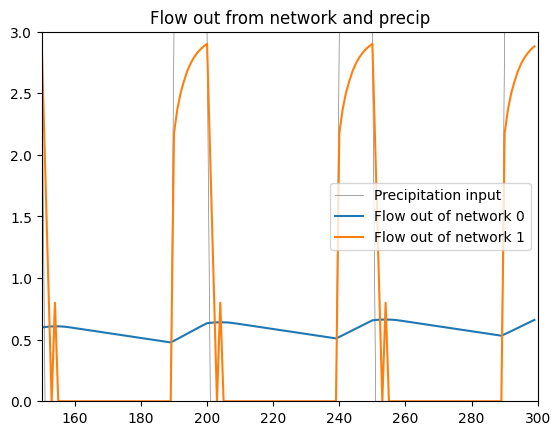

In [7]:
if DO_PLOT:
    # startplt = 0
    # endplt = 250

    # plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    # plt.plot(network_outflow_list_0, label="Flow out of network 0")
    # plt.plot(network_outflow_list_1, label="Flow out of network 1")
    # plt.xlim([startplt, endplt])
    # tensor_version = torch.tensor(network_precip_input_list)
    # max_val = torch.max(tensor_version[startplt:endplt]).item()
    # plt.ylim([0, max_val])
    # plt.legend()
    # plt.title("Warmup period")
    # plt.show()
    # plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [8]:
y_pred, loss = train_ncnn(bucket_nn, network_precip_tensor, network_outflow_tensor_0)
network_outflow_list_1 = list(y_pred.detach().numpy())
print(bucket_net.theta)
print(bucket_net.theta.grad)
print(bucket_nn.ncn.theta)
print(bucket_nn.ncn.theta.grad)

loss: 1.2367, theta: tensor([0.5617, 0.5054], grad_fn=<SelectBackward0>)
loss: 1.2236, theta: tensor([0.5631, 0.4781], grad_fn=<SelectBackward0>)
loss: 1.2165, theta: tensor([0.5645, 0.4379], grad_fn=<SelectBackward0>)
loss: 1.1239, theta: tensor([0.5654, 0.3657], grad_fn=<SelectBackward0>)
loss: 0.9312, theta: tensor([0.5651, 0.2663], grad_fn=<SelectBackward0>)
loss: 0.7026, theta: tensor([0.5651, 0.1967], grad_fn=<SelectBackward0>)
loss: 0.3844, theta: tensor([0.5659, 0.1270], grad_fn=<SelectBackward0>)
loss: 0.1242, theta: tensor([0.5674, 0.0802], grad_fn=<SelectBackward0>)
loss: 0.0239, theta: tensor([0.5688, 0.0543], grad_fn=<SelectBackward0>)
loss: 0.0171, theta: tensor([0.5691, 0.0496], grad_fn=<SelectBackward0>)
loss: 0.0139, theta: tensor([0.5693, 0.0467], grad_fn=<SelectBackward0>)
loss: 0.0138, theta: tensor([0.5693, 0.0465], grad_fn=<SelectBackward0>)
loss: 0.0136, theta: tensor([0.5694, 0.0463], grad_fn=<SelectBackward0>)
loss: 0.0134, theta: tensor([0.5694, 0.0461], grad_

/tmp/ipykernel_3496/4120477293.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(bucket_nn.ncn.theta.grad)


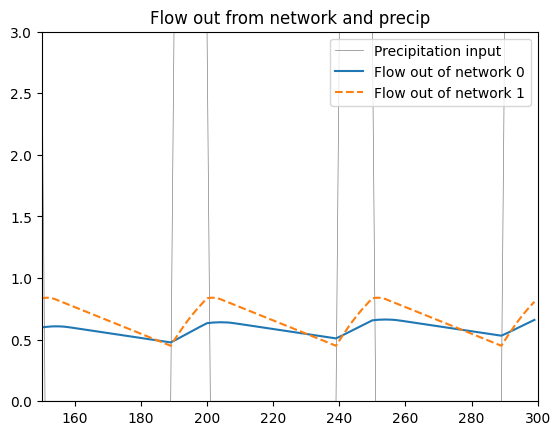

In [9]:
if DO_PLOT:

    # startplt = 0
    # endplt = 250

    # plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    # plt.plot(network_outflow_list_0, label="Flow out of network 0")
    # plt.plot(network_outflow_list_1, label="Flow out of network 1")
    # plt.xlim([startplt, endplt])
    # network_precip_tensor = torch.tensor(network_precip_input_list)
    # max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    # plt.ylim([0, max_value])
    # plt.legend()
    # plt.title("Warmup period")
    # plt.show()
    # plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, "--", label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [10]:
bucket_net.network

{0: {'H': tensor([5.2883]),
  'S': tensor([[[0.3822, 0.4634]]]),
  's_q': tensor([[1.2334]])},
 1: {'H': tensor([54.9151]),
  'S': tensor([[[0.9625, 0.0822]]]),
  's_q': tensor([[0.6605]])}}

In [11]:
bucket_nn.ncn.network

{0: {'H': tensor([3.3739]),
  'S': tensor([[[0.7576, 0.2793]]]),
  's_q': tensor([[1.4136]])},
 1: {'H': tensor([30.1622]),
  'S': tensor([[[0.4031, 0.7347]]]),
  's_q': tensor([[0.8083]])}}

In [12]:
bucket_net.theta

tensor([0.2426, 0.2457], requires_grad=True)

In [13]:
bucket_nn.ncn.theta

tensor([0.5695, 0.0449], grad_fn=<SelectBackward0>)

In [14]:
origional_bucket_theta

tensor([0.5617, 0.5054])

In [15]:
torch.sum(bucket_nn.ncn.theta - origional_bucket_theta)

tensor(-0.4527, grad_fn=<SumBackward0>)

In [16]:
bucket_nn.ncn.theta - origional_bucket_theta

tensor([ 0.0078, -0.4605], grad_fn=<SubBackward0>)